[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb)

# Visualizing Conv filters using ActivationMaximization

## Preparation

### Install libraries

At first, when you didn't yet installed `tf-keras-vis` in your environment such Google Colab, please run the cell below.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade tf-keras-vis tensorflow matplotlib

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

First, you MUST define a modifier to replace the model output to target layer's output that has filters you want to visualize.

In [3]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

### Create ActivationMaximization Instnace

If `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it may take a while.
Here, because it does NOT need to do so, setting False.

In [4]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Score function

You MUST define `score` function that return arbitrary filter values. Here, it returns the value corresponding 63th filter of `block5_conv3` layer. ActivationMaximization will maximize the filter value.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 63
score = CategoricalScore(filter_number)

# Instead of CategoricalScore function object, you can define the scratch function such as below:
def score_function(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the score function. Here, we try to visualize a convolutional filter.

Steps: 0050,	Scores: [[7.014184474945068]],	Regularizations: [('TotalVariation2D', [2.681337594985962]), ('Norm', [0.004056085832417011])],
Steps: 0100,	Scores: [[7.786973476409912]],	Regularizations: [('TotalVariation2D', [2.781198024749756]), ('Norm', [0.004979977384209633])],
Steps: 0150,	Scores: [[8.248801231384277]],	Regularizations: [('TotalVariation2D', [2.896961212158203]), ('Norm', [0.005956003908067942])],
Steps: 0200,	Scores: [[7.404984474182129]],	Regularizations: [('TotalVariation2D', [2.8743836879730225]), ('Norm', [0.006734353955835104])],


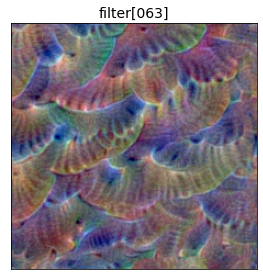

CPU times: user 12min 50s, sys: 1min 54s, total: 14min 44s
Wall time: 5min 51s


In [8]:
%%time
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate max activation
images = activation_maximization(score,
                                 callbacks=[Logger(interval=50),
                                            GifGenerator2D('hoge')])
image = images[0]

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (4, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Score function

When visualizing multiple convolutional filters, you MUST define Score function that return arbitrary filter values for each layer.
Here, we use `SmoothedCategoricalScore` that add noise to score to smooth score funtion and then accomplish getting clear image.

In [8]:
from tf_keras_vis.utils.scores import SmoothedCategoricalScore

filter_numbers = [63, 132, 320]
score = SmoothedCategoricalScore(filter_numbers)

### Create SeedInput values

And then, beforehand, you MUST create seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually create seed-inputs whose samples-dim is as many as the number of the filters you want to generate.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), -1., 1.)

### Visualize

Here, we will visualize 3 images while `steps` option is to be 512 to get clear images.

Steps: 0050,	Scores: [[7.33819055557251, 7.901632670836989e-06, 8.459746360778809]],	Regularizations: [('TotalVariation2D', [0.3650226891040802, 0.11729783564805984, 0.3788613975048065]), ('Norm', [0.004868222400546074, 0.00039311713771894574, 0.005375063046813011])],
Steps: 0100,	Scores: [[9.535411834716797, 7.913804438430816e-06, 10.764907836914062]],	Regularizations: [('TotalVariation2D', [0.39011454582214355, 0.11987552791833878, 0.4105345606803894]), ('Norm', [0.006280031055212021, 0.0003895797417499125, 0.006786966696381569])],
Steps: 0150,	Scores: [[8.486538887023926, 7.89911428000778e-06, 10.196149826049805]],	Regularizations: [('TotalVariation2D', [0.3921356499195099, 0.12504255771636963, 0.42145249247550964]), ('Norm', [0.007157419342547655, 0.0004190550243947655, 0.007526533678174019])],
Steps: 0200,	Scores: [[9.583778381347656, 7.915851711004507e-06, 10.971816062927246]],	Regularizations: [('TotalVariation2D', [0.40347588062286377, 0.12618409097194672, 0.4292314648628235]),

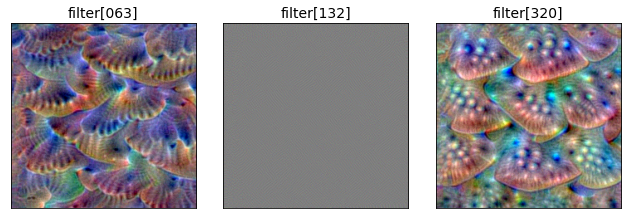

CPU times: user 46min 26s, sys: 5min 10s, total: 51min 36s
Wall time: 21min 21s


In [10]:
%%time
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate max activation
images = activation_maximization(score,
                                 seed_input=seed_input, # To generate multiple images
                                 callbacks=[Logger(interval=50),
                                            GifGenerator2D('hoge')])

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()